The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 实战 Kaggle 比赛：图像分类（CIFAR-10）
:label:`sec_kaggle_cifar10`

到目前为止，我们一直在使用深度学习框架的高级 API 直接获取 Tensor 格式的图像数据集。但是，自定义图像数据集通常以图像文件的形式出现。在本节中，我们将从原始图像文件开始，然后逐步整理、阅读，然后将它们转换为张量格式。 

我们在 :numref:`sec_image_augmentation` 中尝试了 CIFAR-10 数据集，这是计算机视觉中的重要数据集。在本节中，我们将运用我们在前几节中学到的知识来练习 CIFAR-10 图像分类的 Kaggle 比赛。比赛的网址是 https://www.kaggle.com/c/cifar-10 

:numref:`fig_kaggle_cifar10` 展示了该比赛的网页信息。为了便于提交结果，请先在Kaggle网站上注册账号。

![CIFAR-10 image classification competition webpage information. The competition dataset can be obtained by clicking the "Data" tab.](../img/kaggle-cifar10.png)
:width:`600px`
:label:`fig_kaggle_cifar10`


In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 获取和整理数据集

比赛数据集分为训练集和测试集，分别包含 50000 张和 300000 张图像。在测试集中，10000 张图像将用于评估，而剩下的 290000 张图像将不会进行评估：包含它们只是为了使其难以作弊
*手动 * 标记测试集的结果。
此数据集中的图像都是 png 颜色（RGB 通道）图像文件，其高度和宽度均为 32 像素。这些图片共涵盖 10 个类别，即飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车。:numref:`fig_kaggle_cifar10` 的左上角显示了数据集中飞机、汽车和鸟类的图像。 

### 下载数据集

登录 Kaggle 后，我们可以点击 :numref:`fig_kaggle_cifar10` 中显示的 CIFAR-10 图像分类竞赛网页上的 “数据” 选项卡，然后单击 “全部下载” 按钮下载数据集。在 `../data` 中解压下载的文件并在其中解压缩 `train.7z` 和 `test.7z` 后，您将在以下路径中找到整个数据集： 

* `../data/cifar-10/train/[1-50000].png`
* `../data/cifar-10/test/[1-300000].png`
* `../data/cifar-10/trainLabels.csv`
* `../data/cifar-10/sampleSubmission.csv`

`train` 和 `test` 目录分别包含训练和测试图像，`trainLabels.csv` 为训练图像提供标签，`sample_submission.csv` 是示例提交文件。 

为了便于入门，我们提供了包含前 1000 个训练图像和 5 个随机测试图像的数据集的小规模样本。要使用 Kaggle 竞争的完整数据集，您需要将以下 `demo` 变量设置为 `False`。


In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### 整理数据集

我们需要组织数据集来促进模型训练和测试。让我们首先阅读 csv 文件中的标签。以下函数返回一个字典，该字典将文件名的非扩展名部分映射到其标签。


In [3]:
#@save
def read_csv_labels(fname):
    """Read `fname` to return a filename to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


接下来，我们定义 `reorg_train_valid` 函数来将验证设置从原始训练集中拆分。此函数中的参数 `valid_ratio` 是验证集中的示例数与原始训练集中示例数的比率。更具体地说，让 $n$ 作为实例最少的课堂图像数量，而 $r$ 是比率。验证集将为每个课程拆分 $\max(\lfloor nr\rfloor,1)$ 张图像。让我们以 `valid_ratio=0.1` 为例。由于最初的训练套装有 50000 张图像，因此 `train_valid_test/train` 路径中将有 45000 张图像用于训练，而其他 5000 张图像将作为路径 `train_valid_test/valid` 中设置的验证进行拆分。组织数据集后，同类的图像将被放置在同一文件夹下。


In [4]:
#@save
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    # The number of examples of the class that has the fewest examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

下面的 `reorg_test` 函数组织了预测期间数据加载的测试集。


In [5]:
#@save
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

最后，我们使用一个函数来调用上面定义的 `read_csv_labels`、`reorg_train_valid` 和 `reorg_test` 函数。


In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

在这里，我们只将数据集的小规模样本的批量大小设置为 4。在训练和测试 Kaggle 比赛的完整数据集时，应将 `batch_size` 设置为更大的整数，例如 128。我们将 10％ 的训练示例作为调整超参数的验证集。


In [7]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## 图像增强

我们使用图像增强来解决过度适合问题。例如，在训练期间，可以随机水平翻转图像。我们还可以对彩色图像的三个 RGB 通道执行标准化。下面列出了您可以调整的其中一些操作。


In [8]:
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。


In [9]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## 读取数据集

接下来，我们读取由原始图像文件组成的组织数据集。每个示例都包括一张图片和一个标签。


In [10]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

在训练期间，我们需要指定上面定义的所有图像增强操作。当验证集在超参数调整过程中用于模型评估时，不应引入图像增强的随机性。在最终预测之前，我们根据组合训练集和验证集训练模型进行训练，以充分利用所有标记的数据。


In [11]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## 定义模型


我们定义了 :numref:`sec_resnet` 中描述的 Resnet-18 模型。


In [12]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

## 定义训练函数

我们将根据模型在验证集上的性能选择模型并调整超参数。在下面，我们定义了模型训练函数 `train`。


In [13]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## 训练和验证模型

现在，我们可以训练和验证模型。以下所有超参数都可以调整。例如，我们可以增加纪元的数量。当 `lr_period` 和 `lr_decay` 分别设置为 50 和 0.1 时，优化算法的学习速率将在每 50 个纪元后乘以 0.1。只是为了示范，我们在这里只训练一个时代。


loss nan, train acc 0.102, valid acc 0.100
123.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


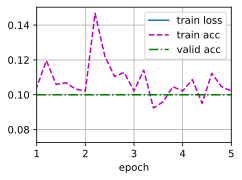

In [14]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## 在 Kaggle 上对测试集进行分类并提交结果

在获得具有超参数的有前途的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。


loss 2.520, train acc 0.090
145.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


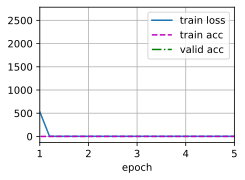

In [15]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

上面的代码将生成一个 `submission.csv` 文件，其格式符合 Kaggle 竞争的要求。向 Kaggle 提交结果的方法与 :numref:`sec_kaggle_house` 中的方法类似。 

## 小结

* 将包含原始图像文件的数据集组织为所需格式后，我们可以读取它们。


* 我们可以在图像分类竞赛中使用卷积神经网络和图像增强。


## 练习

1. 在这场 Kaggle 比赛中使用完整的 CIFAR-10 数据集。将 `batch_size` 和时代数分别更改为 128 和 100。看看你在这场比赛中能达到什么准确度和排名。你能进一步改进它们吗？
1. 不使用图像增强时，您能获得什么准确性？


[Discussions](https://discuss.d2l.ai/t/1479)
